A recent alternative to feed-forward neural networks are the
{\sl Kolmogorov--Arnold networks} (KANs) introduced by Liu
et al. (2024)
.
Inspired by the Kolmogorov--Arnold representation theorem, which
shows that every continuous function $\phi \colon [0,1]^d \to \mathbb{R}$ can be written as
$$
\phi(x) = \sum_{i =1}^{2d +1} \Phi_i \{\sum_{j=1}^d \phi_{i,j}(x_j)\}
$$
for one-dimensional functions $\phi_{i,j}:[0,1]\to\mathbb{R}$ and
$\Phi_i :\mathbb{R}\to\mathbb{R}$, a KAN is a composition
$$
{\bf \Phi}_L \circ \dots \circ {\bf \Phi}_1 \colon \mathbb{R}^d \to \mathbb{R}^{n}
$$
of KAN-layers of the form
$$
{\bf \Phi}_l(x)= \begin{pmatrix}
\sum_{j=1}^{d_{l-1}} \phi^l_{1,j}(x_j)\\
\vdots \\
\sum_{j=1}^{d_{l-1}} \phi^l_{d_l,j}(x_j)
\end{pmatrix}, \quad x \in \mathbb{R}^{d_{l-1}},
$$
where the one-dimensional functions $\phi^l_{i,j} \colon \mathbb{R} \to \mathbb{R}$
are specified as
$$
\sum_i c_i B_i
$$
for given basis functions $B_i$ and learnable parameters $c_i \in \mathbb{R}$.

The canonical choice of $B_i$ are polynomial splines with learnable grid-points. But,
depending on the situation, some of the $B_i's$ can also be specified as
special functions such as $\exp, \log, \sin, \cos, \tan$.

KANs hold great potential in approximation tasks requiring high precision.
Moreover, in cases, where the Legendre transform
has a closed form expression in terms of special functions, KANs can be employed to obtain
the exact solution using symbolic regression. This is a significant advantage
compared to numerical approximation since it uncovers the underlying mathematical
structure.

To illustrate symbolic regression with KANs, we consider the
following two-dimensional convex functions:


* quadratic: $f(x) = \sum_{i=1}^2 x^2_i$
* negative logarithm: $f(x) = -\sum_{i=1}^2 \log(x_i)$,
* negative entropy: $f(x) = \sum_{i=1}^2 x_i \log(x_i)$.

Their Legendre transforms are known in closed form:


* quadratic: $f^*(x) = \sum_{i=1}^2 x^2_i/4$
* negative logarithm: $f^*(x) = -\sum_{i=1}^2 \log(-x_i) - 2$
* negative entropy: $f^*(x) = \sum_{i=1}^2 \exp(x_i - 1)$.


In all three cases we performed a symbolic regression with KANs to minimize the
empirical squared error \eqref{min} for a training set   sampled uniformly from
the square $[1,10]^2$. We added polynomials up to the third order,
$\exp$ and $\log$ as basis functions.

As can be seen, KANs are able to find the correct symbolic expressions
for the Legendre transforms of these functions with the right constants
(up to rounding errors).


In [ ]:
# # Install the specified versions of the required packages
# # !pip install matplotlib==3.6.2
# # !pip install numpy==1.24.4
# !pip install scikit-learn==1.1.3
# !pip install setuptools==65.5.0
# !pip install sympy==1.11.1



In [ ]:
# !pip install torch==2.2.2
# # !pip install tqdm==4.66.2

In [ ]:
# Clone the repository
!git clone https://github.com/KindXiaoming/pykan.git

# Navigate into the repository directory
%cd pykan

# Check out the specific version
# !git checkout tags/v0.2.2 -b v0.2.2
!git checkout tags/v0.2.4 -b v0.2.4
# !git checkout tags/v0.1.2 -b v0.1.2
# Install the package in editable mode
!pip install -e .

fatal: destination path 'pykan' already exists and is not an empty directory.
/content/pykan/pykan/pykan/pykan/pykan/pykan/pykan
M	pykan.egg-info/PKG-INFO
Switched to a new branch 'v0.2.4'
Obtaining file:///content/pykan/pykan/pykan/pykan/pykan/pykan/pykan
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pykan
    Found existing installation: pykan 0.2.2
    Uninstalling pykan-0.2.2:
      Successfully uninstalled pykan-0.2.2
  Running setup.py develop for pykan


In [ ]:
import matplotlib
import numpy as np
import sklearn
import setuptools
import sympy
import torch
import tqdm

print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("setuptools version:", setuptools.__version__)
print("sympy version:", sympy.__version__)
print("torch version:", torch.__version__)
print("tqdm version:", tqdm.__version__)

matplotlib version: 3.7.1
numpy version: 1.26.4
scikit-learn version: 1.3.2
setuptools version: 71.0.4
sympy version: 1.13.1
torch version: 2.3.1+cu121
tqdm version: 4.66.4


In [ ]:
from kan import *
torch.set_default_dtype(torch.float64)


# Some saving/loading utils:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, TensorDataset
import os

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Print the name of the GPU if available
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Disable deterministic algorithms
torch.use_deterministic_algorithms(False)

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, d):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(d, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, d)
        self.tanh = nn.Tanh()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('linear'))
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x



# Define gradient mapping
def h(x, f):
    x = x.clone().detach().requires_grad_(True)
    y = f(x)
    y.backward(torch.ones_like(y), retain_graph=True)
    return x.grad



Using device: cpu


In [ ]:
def approximate_inverse_sampling_generator(cfg, miny, maxy, autoencoder):
    # Move the autoencoder to CPU and set to evaluation mode
    autoencoder.to('cpu')
    autoencoder.eval()
    while True:
        # Generate uniform samples in the latent space range [miny, maxy] with the correct dtype
        latent_samples = torch.rand(cfg.batch_size, cfg.dim, dtype=torch.float64) * (maxy - miny) + miny
        with torch.no_grad():
            # Pass the samples through the autoencoder's forward method
            decoded_samples = autoencoder(latent_samples.to('cpu').to(torch.float64))
            decoded_samples = decoded_samples.to(torch.float64)
        yield decoded_samples

def load_model_only(path, model):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded old weights successfully.")
    else:
        print("No saved weights found. Starting training from scratch.")


### Domain:

In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import time

# Define the Config namedtuple
Config = namedtuple("Config", [
    "dim",                           # Dimensionality of the space
    "layer_widths",                  # Layer widths for potential neural network usage
    "num_epochs",                    # Number of epochs for training
    "batch_size",                    # Batch size for sampling
    "steps",                         # Number of steps (currently unused)
    "minval_x",                        # Minimum value for uniform sampling , primal-space
    "maxval_x",                        # Maximum value for uniform sampling
    "minval_y",                        # Minimum value for uniform sampling , dual-space
    "maxval_y",                        # Maximum value for uniform sampling
    "epsilon",                       # Epsilon value for convergence criteria (currently unused)
    "beta",                          # Beta value for regularization or other purposes
    "convrg_eps",                    # Convergence epsilon (currently unused)
    "learning_rate",                 # Learning rate for optimization (currently unused)
    "l2_regularization_coefficient", # L2 regularization coefficient (currently unused)
    "function_name",                 # Name of the primal function
    "function_star_name",            # Name of the dual function
])

# Primal QUADRATIC:
def square(x):
    return torch.sum(x * x, dim=-1, keepdim=True)

# Dual:
def square_star_true(x):
    return torch.sum(x * x, dim=-1) / 4

# Primal QUADRATIC OVER LINEAR (dividing by the last component of x)
def quad_over_lin(x):
    numerator = torch.sum(x[:-1]**2)
    denominator = x[-1]
    return numerator / denominator

# Primal NEGATIVE-ENTROPY
def negative_entropy(x):
    return torch.sum(x * torch.log(x), dim=-1, keepdim=True)

# Dual
def negative_entropy_star_true(x):
    return torch.sum(torch.exp(x - 1), dim=-1)

# Primal Negative Logarithm
def negative_logarithm(x):
    return -torch.sum(torch.log(x), dim=-1, keepdim=True)

# Dual of the Negative Logarithm
def negative_logarithm_star_true(y):
    return -torch.sum(torch.log(-y), dim=-1) - y.shape[-1]

# Map the string names to the actual functions
function_mapping = {
    "quadratic": square,
    "quadratic_star_true": square_star_true,
    "quad_over_lin": quad_over_lin,
    "negative_entropy": negative_entropy,
    "negative_entropy_star_true": negative_entropy_star_true,
    "negative_logarithm": negative_logarithm,
    "negative_logarithm_star_true": negative_logarithm_star_true,
}

# Initialize configuration
cfg = Config(
    dim=2,                           # Dimensionality of 2
    layer_widths=(128, 64),          # Example layer widths for neural network
    num_epochs = 4,                # 30000 epochs for training
    batch_size=3200,                  # Batch size of 320
    minval_x=1,                        # Minimum value for uniform sampling X
    maxval_x=10,                       # Maximum value for uniform sampling X
    minval_y=-0.8,                        # Minimum value for uniform sampling Y (grad. space) -0.8, -0.2  # n.log
    maxval_y=-0.2,                       # Maximum value for uniform sampling Y (grad. space) 1, 3 for neg entr
    steps=0,                         # Steps (currently unused)
    epsilon=0.01,                    # Epsilon for convergence (currently unused)
    beta=0.01,                       # Beta value
    convrg_eps=1e-5,                 # Convergence epsilon (currently unused)
    learning_rate=3e-3,              # Learning rate for optimization (currently unused)
    l2_regularization_coefficient=1e-6, # L2 regularization coefficient (currently unused)
    function_name= "negative_logarithm",          # Name of the primal function
    function_star_name= "negative_logarithm_star_true"# Name of the dual function
    # function_name= "quadratic",          # Name of the primal function
    # function_star_name= "quadratic_star_true"# Name of the dual function
    # function_name= "negative_entropy",          # Name of the primal function
    # function_star_name= "negative_entropy_star_true"# Name of the dual function
)

# Initialize the autoencoder
d = cfg.dim  # Dimensionality
autoencoder = Autoencoder(d).to(device)

# Function to retrieve functions based on names in the configuration
def get_functions(cfg):
    primal_function = function_mapping[cfg.function_name]
    dual_function = function_mapping[cfg.function_star_name]
    return primal_function, dual_function

# Get the primal and dual functions based on the config
primal_function, dual_function = get_functions(cfg)

# Uniform sampling random generator
def uniform_sampling_random_generator(cfg, minval=1, maxval=10):
    while True:
        samples = torch.rand(cfg.batch_size, cfg.dim) * (maxval - minval) + minval
        yield samples

# Normal sampling random generator
def normal_sampling_random_generator(cfg, mean=0.0, std=1.0):
    while True:
        samples = torch.randn(cfg.batch_size, cfg.dim) * std + mean
        yield samples

# Lognormal sampling random generator
def lognormal_sampling_random_generator(cfg, mean=0.0, std=1.0):
    while True:
        samples = torch.exp(torch.randn(cfg.batch_size, cfg.dim) * std + mean)
        yield samples

# Pareto sampling random generator
def pareto_sampling_random_generator(cfg, scale=1.0, shape=2.0):
    while True:
        samples = (torch.rand(cfg.batch_size, cfg.dim) ** (-1.0 / shape)) * scale
        yield samples

# Compute the gradient of the primal function
def compute_gradients(func, x):
    x = x.clone().detach().requires_grad_(True)
    y = func(x)
    y.backward(torch.ones_like(y))
    return x.grad

# Get the next batch of data
def get_next_batch(train_generator):
    x = next(train_generator).reshape(-1, cfg.dim)
    x.requires_grad_(True)  # Ensure requires_grad is set to True

    f_x = primal_function(x)  # Compute primal function

    finite_fx_mask = torch.isfinite(f_x).squeeze()  # Check for finiteness and flatten the mask

    x_finite_fx = x[finite_fx_mask]
    f_x_finite_fx = f_x[finite_fx_mask]

    if x_finite_fx.requires_grad:
        grad_f_x_finite_fx = compute_gradients(primal_function, x_finite_fx)
        # random_probs = torch.rand_like(grad_f_x_finite_fx)

        # grad_fx_prob_mask = (grad_f_x_finite_fx >= 0.01) | ((grad_f_x_finite_fx < 0.01) & (random_probs < 0.05))
        # grad_fx_strict_mask = (grad_f_x_finite_fx <= 10)
        # combined_mask = grad_fx_prob_mask.all(dim=1) & grad_fx_strict_mask.all(dim=1)

        x_filtered_final = x_finite_fx#[combined_mask]
        f_x_filtered_final = f_x_finite_fx#[combined_mask]
        grad_f_x_filtered_final = grad_f_x_finite_fx#[combined_mask]

        return x_filtered_final, f_x_filtered_final, grad_f_x_filtered_final
    else:
        return None, None, None # Handle the case where requires_grad is still False, if necessary

# Create targets for KAN
def create_targets_for_kan(primal_values, inputs_x, inputs_grad_f_x):
    term1 = torch.sum(inputs_x * inputs_grad_f_x, dim=1, keepdim=True)
    targets = term1 - primal_values
    return targets

# Calculate statistics
def calculate_statistics(eval_batch_x, eval_grad_f_x, preds, vmap_f_star_true, loss_value):
    # Calculate vmap_f_star_true values
    f_star_values = vmap_f_star_true(eval_grad_f_x)

    # Identify points where vmap_f_star_true gives infinity
    is_finite = torch.isfinite(f_star_values)

    # Apply the mask to filter out infinite points
    finite_preds = preds[is_finite]
    finite_f_star_values = f_star_values[is_finite]

    # Reshape for calculation
    finite_preds_reshaped = finite_preds.reshape(-1, 1)
    finite_f_star_values_reshaped = finite_f_star_values.reshape(-1, 1)

    # Calculate RMSE excluding infinite points
    errors = finite_preds_reshaped - finite_f_star_values_reshaped
    rmse_acc = torch.sqrt(torch.mean(errors ** 2))

    # Calculate max_acc excluding infinite points
    max_acc = torch.max(torch.abs(errors))

    # Calculate Mean Relative Error (MRE), avoiding division by zero
    relative_errors = torch.where(finite_f_star_values_reshaped != 0,
                                  torch.abs(errors / finite_f_star_values_reshaped),
                                  torch.zeros_like(errors))
    mre = torch.mean(relative_errors)

    RMSR = torch.sqrt(torch.tensor(loss_value)) # root of mean square residual

    return rmse_acc.item(), max_acc.item(), RMSR.item(), mre.item()

# Plotting function
def plot_nn_vs_true(model_kan, vmap_f_star_true, input_range=(0, 10), resolution=100):
    # Create a grid of values within the specified input range
    x_values = torch.linspace(input_range[0], input_range[1], resolution)
    X1, X2 = torch.meshgrid(x_values, x_values, indexing='ij')
    grid_shape = X1.shape
    grid_points = torch.stack([X1.ravel(), X2.ravel()], dim=1)

    # Get predictions from the neural network
    nn_preds = model_kan.forward(grid_points).detach().cpu().numpy().reshape(grid_shape)

    # Get true values using vmap_f_star_true function
    true_vals = vmap_f_star_true(grid_points).reshape(grid_shape)

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.contourf(X1.cpu().numpy(), X2.cpu().numpy(), true_vals, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title('True Function')
    plt.xlabel('$x_1$')
    plt.ylabel('$y_2$')

    plt.subplot(1, 2, 2)
    plt.contourf(X1.cpu().numpy(), X2.cpu().numpy(), nn_preds, levels=50, cmap='viridis')
    plt.colorbar()
    _, _, train_grad_f_x = get_next_batch(train_generator)
    plt.scatter(train_grad_f_x[:, 0].cpu().numpy(), train_grad_f_x[:, 1].cpu().numpy(), color='red')
    plt.title('Neural Network Predictions')
    plt.xlabel('$x_1$')
    plt.ylabel('$y_2$')

    plt.show()

# Assuming a specific implementation for vmap_f_star_true
def vmap_f_star_true(batch_x):
    return torch.stack([dual_function(x) for x in batch_x])

def find_model_weights(model_weights_path, function_name):
    weight_files = [f for f in os.listdir(model_weights_path) if f.startswith(function_name)]
    return sorted(weight_files)

## Function to select a model weight file
def select_model_weight(weight_files):
    if not weight_files:
        return None
    print("Available model weights:")
    for idx, file in enumerate(weight_files):
        print(f"[{idx + 1}] {file}")
    while True:
        try:
            choice = int(input("Select a model weight file to load (enter the number): ")) - 1
            if 0 <= choice < len(weight_files):
                return weight_files[choice]
            else:
                print("Selection out of range. Running uniform distribution.")
                return None
        except ValueError:
            print("Invalid input. Please enter a number.")

# Create the directory to save model weights if it does not exist
model_weights_path = '/content/model_weights'
os.makedirs(model_weights_path, exist_ok=True)

# Check if the folder exists and prompt the user to load old weights if available
weight_files = find_model_weights(model_weights_path, cfg.function_name)
if weight_files:
    selected_weight = select_model_weight(weight_files)
    if selected_weight:
        weight_path = os.path.join(model_weights_path, selected_weight)
        load_model_only(weight_path, autoencoder)
        miny, maxy = cfg.minval_y, cfg.maxval_y# -0.8, -0.2  # n.log
        train_generator = approximate_inverse_sampling_generator(cfg, miny, maxy, autoencoder)
    else:
        train_generator = uniform_sampling_random_generator(cfg)
        print("uniform sampling")
else:
    # NO AE
    train_generator = uniform_sampling_random_generator(cfg)
    print("no ae file: continue with uniform sampling")



Available model weights:
[1] negative_logarithm_autoencoder_epoch_40.pt
Select a model weight file to load (enter the number): 1
Loaded old weights successfully.


In [ ]:
def create_dataset(train_generator):
    # Get next training batch
    batch_x, train_f_x, train_grad_f_x = get_next_batch(train_generator)
    if batch_x is None:
        return None  # Exit if the batch is None

    # Detach tensors
    batch_x = batch_x.detach()
    train_f_x = train_f_x.detach()
    train_grad_f_x = train_grad_f_x.detach()

    # Get next evaluation batch
    eval_x, eval_f_x, eval_grad_f_x = get_next_batch(train_generator)
    if eval_x is None:
        return None  # Exit if the batch is None

    # Detach tensors
    eval_x = eval_x.detach()
    eval_f_x = eval_f_x.detach()
    eval_grad_f_x = eval_grad_f_x.detach()

    # Create targets
    targets_for_kan_train = create_targets_for_kan(train_f_x, batch_x, train_grad_f_x)
    targets_for_kan_test = create_targets_for_kan(eval_f_x, eval_x, eval_grad_f_x)

    # Create dataset dictionary
    dataset = {
        'train_input': train_grad_f_x,
        'train_label': targets_for_kan_train,
        'test_input': eval_grad_f_x,
        'test_label': targets_for_kan_test
    }

    return dataset, eval_x, eval_f_x, eval_grad_f_x


def print_first_elements(dataset):
    print("First element in 'train_input':", dataset['train_input'][0])
    print("First element in 'train_label':", dataset['train_label'][0])
    print("First element in 'test_input':", dataset['test_input'][0])
    print("First element in 'test_label':", dataset['test_label'][0])

In [ ]:

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model_kan = KAN(width=[2,5,1], grid=5, k=3, seed=0)
# model_kan.tree()

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
# Timing and progress tracking

tic = time.time()
epoch = 0
N = 25

num_epochs = 100

# Training and evaluation loop
while epoch < num_epochs:
    dataset, eval_x, eval_f_x, eval_grad_f_x = create_dataset(train_generator)
    # print_first_elements(dataset)

    results = model_kan.fit(dataset, opt="LBFGS", steps=N, lamb = 0.001)


    epoch += num_epochs/2

toc = time.time()
duration = toc - tic


| train_loss: 1.68e-02 | test_loss: 1.67e-02 | reg: 7.45e+00 | : 100%|█| 25/25 [00:35<00:00,  1.43s/


saving model version 0.1


| train_loss: 1.68e-02 | test_loss: 1.71e-02 | reg: 7.35e+00 | : 100%|█| 25/25 [00:22<00:00,  1.11it

saving model version 0.2


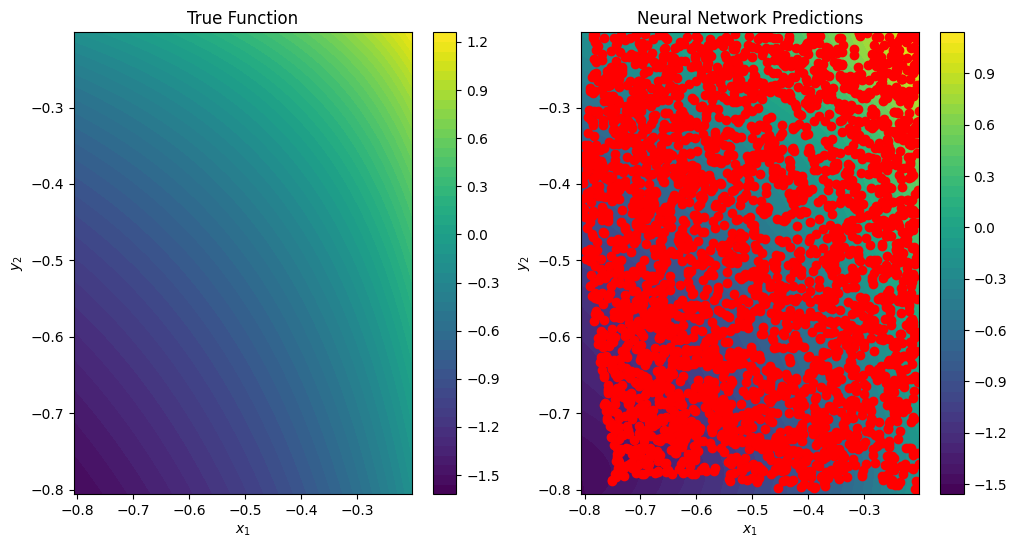

RMSE: 1.5396938126224524, Max Acc: 4.33619529953862, RMSR: 0.13075760790913674, MRE: 13.769061173335219


In [ ]:
eval_grad_f_x = dataset['test_input']

# AE# Example usage of the plot function
y_minval = torch.min(eval_grad_f_x)
y_maxval = torch.max(eval_grad_f_x)


plot_nn_vs_true(model_kan, vmap_f_star_true, input_range=(y_minval, y_maxval), resolution=100)

# Example usage of the statistics function
loss_value =results['test_loss'][-1]  # Replace with actual loss value
rmse_acc, max_acc, RMSR, mre = calculate_statistics(eval_x, eval_grad_f_x, eval_f_x, vmap_f_star_true, loss_value)
print(f"RMSE: {rmse_acc}, Max Acc: {max_acc}, RMSR: {RMSR}, MRE: {mre}")

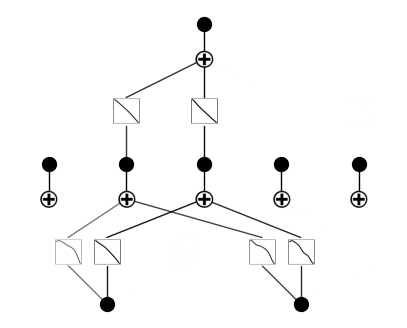

In [ ]:
model_kan.plot()

saving model version 0.3


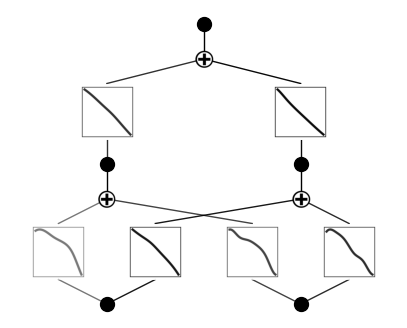

In [ ]:
model = model_kan.prune(node_th = 0.2)
model.plot()

In [ ]:
# dataset = create_dataset(train_generator)[0]
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 7.88e-05 | test_loss: 8.28e-05 | reg: 8.78e+00 | : 100%|█| 50/50 [00:29<00:00,  1.70it

saving model version 0.4


saving model version 0.5


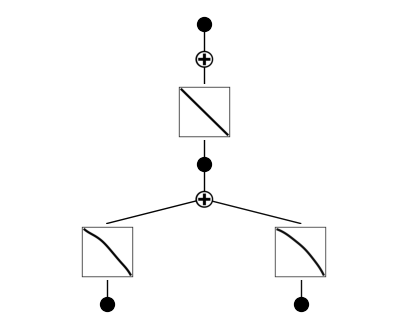

In [ ]:
model = model.prune(node_th = 3*1e-1, edge_th = 0.3) #3*1e-1, edge_th = 0.3
model.plot()

In [ ]:
model.fit(dataset, opt="LBFGS", steps=50);
# dataset = create_dataset(train_generator)[0]
# model.fit(dataset, opt="LBFGS", steps=25);

| train_loss: 7.94e-05 | test_loss: 8.23e-05 | reg: 7.53e+00 | : 100%|█| 50/50 [00:19<00:00,  2.58it

saving model version 0.6


saving model version 0.7


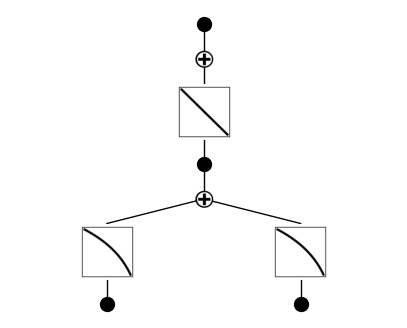

In [ ]:
# model = model.refine(10)
model = model.prune(node_th = 5*1e-1) #3*1e-1, edge_th = 0.3
model.plot()

In [ ]:
dataset = create_dataset(train_generator)[0]
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 7.95e-05 | test_loss: 8.13e-05 | reg: 7.56e+00 | : 100%|█| 50/50 [00:21<00:00,  2.29it

saving model version 0.8


In [ ]:
model = model.refine(10)


saving model version 0.9


In [ ]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.01e-05 | test_loss: 4.36e-05 | reg: 7.56e+00 | : 100%|█| 50/50 [00:22<00:00,  2.21it

saving model version 0.10


saving model version 0.11


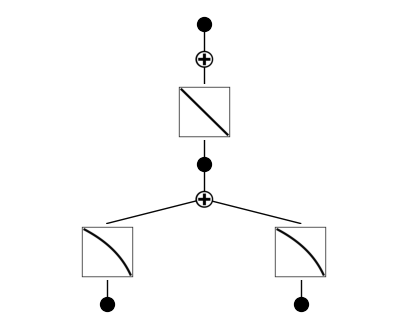

In [ ]:
model = model.prune()
model.plot()

In [ ]:
# model.save_act=True
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

In [ ]:

# model = model.prune(3*1e-1, edge_th = 0.06)
# model.plot()

In [ ]:
# model = model.refine(10)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.00);

saving model version 0.12


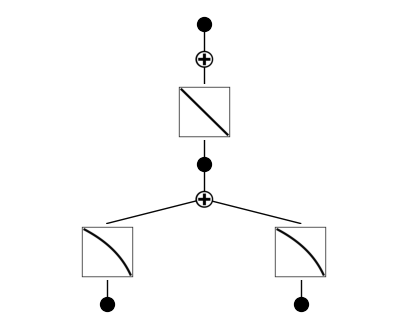

In [ ]:
dataset = create_dataset(train_generator)[0]
model = model.prune(2*1e-1, edge_th = 0.06)
model.plot()

In [ ]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.00);

| train_loss: 7.67e-06 | test_loss: 4.13e-05 | reg: 7.56e+00 | : 100%|█| 50/50 [00:23<00:00,  2.15it

saving model version 0.13


In [ ]:
SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', 'x^5', '1/x', '1/x^2', '1/x^3', '1/x^4', '1/x^5', 'sqrt', 'x^0.5', 'x^1.5', '1/sqrt(x)', '1/x^0.5', 'exp', 'log', 'abs', 'sin', 'cos', 'tan', 'tanh', 'sgn', 'arcsin', 'arccos', 'arctan', 'arctanh', '0', 'gaussian'])

In [ ]:
# add_symbolic('x*log', lambda x: x*torch.log(x))

In [ ]:
# from kan.ckpt import *
# path ='/content/model'
# saveckpt(model, path)
# model_copied = loadckpt(path)

# model_symb = model_copied

model_symb = model

mode =  "auto" #"manual" #

if mode == "manual":
    # manual mode
    model_symb.fix_symbolic(0,0,0,'sin');
    model_symb.fix_symbolic(0,1,0,'x^2');
    model_symb.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x', 'exp', 'log','sqrt','tanh','sin']
    # lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']#['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs','x*log']
    model_symb.auto_symbolic(lib=lib)

fixing (0,0,0) with log, r2=0.9999999963806293, c=2
fixing (0,1,0) with log, r2=0.9999999961897458, c=2
fixing (1,0,0) with x, r2=0.9999999943944649, c=1
saving model version 0.14


In [ ]:
model_symb.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 2.94e-15 | test_loss: 5.82e-16 | reg: 7.56e+00 | : 100%|█| 50/50 [00:04<00:00, 11.89it

saving model version 0.15


In [ ]:
from kan.utils import ex_round

ex_round(model_symb.symbolic_formula()[0][0],4)

-1.0*log(-0.6959*x_1) - 1.0*log(-6.0906*x_2) - 0.5558

In [ ]:
1/0

ZeroDivisionError: division by zero

## Approximate inverse sampling:

In [ ]:
# Uniform sampling random generator
def uniform_sampling_random_generator(cfg, minval=1, maxval=10):
    while True:
        samples = torch.rand(cfg.batch_size, cfg.dim) * (maxval - minval) + minval
        yield samples

# Approximate inverse sampling generator
def approximate_inverse_sampling_generator(cfg, min_y, max_y, autoencoder):
    while True:
        latent_samples = torch.rand(cfg.batch_size, cfg.dim, dtype=torch.float32) * (max_y - min_y) + min_y
        with torch.no_grad():
            decoded_samples = autoencoder(latent_samples.to(device)).to('cpu')
        yield decoded_samples

# Create a data loader using the uniform sampling generator
def create_dataloader(generator, n_samples, batch_size):
    data = []
    for _ in range(n_samples // batch_size):
        data.append(next(generator))
    data = torch.cat(data, dim=0)
    dataset = TensorDataset(data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Create the optimizer
initial_lr = 1e-2
optimizer = optim.Adam(autoencoder.parameters(), lr=initial_lr)
scaler = GradScaler()

# Initialize the generator
gen = uniform_sampling_random_generator(cfg, minval=cfg.minval_x, maxval=cfg.maxval_x)

# Estimate y-space range
def estimate_y_space_range(generator, num_samples):
    x_samples = []
    for _ in range(num_samples // cfg.batch_size):
        x_samples.append(next(generator))
    x_samples = torch.cat(x_samples, dim=0).to(device)
    y_samples = torch.stack([h(xi, primal_function) for xi in x_samples])
    min_y, _ = torch.min(y_samples, dim=0)
    max_y, _ = torch.max(y_samples, dim=0)
    return min_y.to(device), max_y.to(device)

# Estimate the range for y-space
min_y, max_y = estimate_y_space_range(gen, cfg.batch_size * 10)

# Ensure min_y and max_y are on the correct device
min_y = min_y.to(device)
max_y = max_y.to(device)

# Function to compute the reconstruction using the autoencoder
def reconstruction(autoencoder, x):
    encoding_target = torch.stack([h(xi, primal_function) for xi in x])
    decoding = autoencoder(encoding_target)
    return decoding

# Function to compute the reencoding using the autoencoder
def encoder_reconstruction(autoencoder, y):
    decoding_target = autoencoder(y)
    reencoded = torch.stack([h(xi, primal_function) for xi in decoding_target])
    return reencoded

# Loss function for training
def loss_fn(autoencoder, x, y):
    decoding = reconstruction(autoencoder, x)
    decoder_loss = torch.mean((decoding - x) ** 2)

    decoding_target = autoencoder(y)
    reencoded = torch.stack([h(xi, primal_function) for xi in decoding_target])

    # Filter out NaN and Inf values before computing encoder loss
    finite_mask = torch.isfinite(reencoded).all(dim=1) & torch.isfinite(y).all(dim=1)
    reencoded = reencoded[finite_mask]
    y = y[finite_mask]

    encoder_loss = torch.mean((reencoded - y) ** 2) if reencoded.numel() > 0 else torch.tensor(0.0, device=device)

    return decoder_loss, encoder_loss, decoder_loss + encoder_loss

# Save model function
def save_model(model, optimizer, scaler, path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict()
    }
    torch.save(checkpoint, path)

# Load model function
def load_model(path, model, optimizer, scaler):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        print("Loaded weights from:", path)
    else:
        print("No saved weights found at", path)

# Function to list available weight files and allow user selection
def list_and_select_weight_files(model_weights_path, function_name):
    weight_files = [f for f in os.listdir(model_weights_path) if f.startswith(function_name)]
    if not weight_files:
        print("No saved weights found.")
        return None
    weight_files.sort(key=lambda f: int(f.split('_')[-1].split('.')[0]))  # Sort by epoch index
    print("Available weight files:")
    for idx, weight_file in enumerate(weight_files):
        print(f"[{idx+1}] {weight_file}")
    selection = int(input("Select the weight file to load by number: ")) - 1
    return os.path.join(model_weights_path, weight_files[selection])

# Training function
def train_autoencoder(autoencoder, generator, optimizer, scaler, num_epochs, batch_size, start_epoch=0):
    for epoch in range(start_epoch, start_epoch + num_epochs):
        data_loader = create_dataloader(generator, batch_size * 10, batch_size)
        for x in data_loader:
            x = x[0].to(device).requires_grad_(True)

            # Generate a batch of uniform samples in y-space for each batch
            uniform_samples_y = torch.rand(cfg.batch_size, cfg.dim, device=device) * (max_y - min_y) + min_y

            # Filter out inf and nan values
            if torch.isfinite(x).all() and torch.isfinite(uniform_samples_y).all():
                autoencoder.train()
                optimizer.zero_grad()

                with autocast():
                    loss_decoder, loss_encoder, total_loss = loss_fn(autoencoder, x, uniform_samples_y)

                if torch.isnan(total_loss).sum().item() / total_loss.numel() > 0.05:
                    total_loss = loss_decoder

                if torch.isnan(total_loss).sum().item() == total_loss.numel() or torch.isinf(total_loss).sum().item() > 0:
                    print("Skipping batch due to NaN or Inf in total_loss")
                    continue

                # Check for inf/NaN gradients before scaling
                print("Loss (decoder):", loss_decoder.item())
                print("Loss (encoder):", loss_encoder.item())
                print("Has inf/NaN gradients before scaling:",
                      any(torch.isinf(p.grad).any() or torch.isnan(p.grad).any()
                          for p in autoencoder.parameters() if p.grad is not None))

                scaler.scale(total_loss).backward(retain_graph=True)

                # Check for inf/NaN gradients after scaling
                print("Has inf/NaN gradients after scaling:",
                      any(torch.isinf(p.grad).any() or torch.isnan(p.grad).any()
                          for p in autoencoder.parameters() if p.grad is not None))

                scaler.step(optimizer)
                scaler.update()

        # Save the model weights after the last epoch
        if epoch == start_epoch + num_epochs - 1:
            save_model(autoencoder, optimizer, scaler, f'/content/model_weights/{cfg.function_name}_autoencoder_epoch_{epoch+1}.pt')

        # Generate a batch of uniform samples in y-space
        uniform_samples_y = torch.rand(cfg.batch_size, cfg.dim, device=device) * (max_y - min_y) + min_y

        # Decode the uniform samples using the trained autoencoder
        decoded_samples_x = autoencoder(uniform_samples_y)

        # Apply gradient mapping to decoded samples
        gradient_mapped_decoded_samples = torch.stack([h(sample, primal_function) for sample in decoded_samples_x])

        # Plotting the uniform samples in y-space and gradient-mapped decoded samples
        plot_progress(uniform_samples_y, gradient_mapped_decoded_samples, epoch)

        print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Decoder Loss: {loss_decoder.item():.4f}, Encoder Loss: {loss_encoder.item():.4f}")

# Plotting function to observe the progress
def plot_progress(uniform_samples_y, gradient_mapped_decoded_samples, epoch):
    uniform_samples_y = uniform_samples_y.detach().cpu().numpy()
    gradient_mapped_decoded_samples = gradient_mapped_decoded_samples.detach().cpu().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(uniform_samples_y[:, 0], uniform_samples_y[:, 1], color='blue', alpha=0.6, label='Uniform Samples in y-space')
    plt.scatter(gradient_mapped_decoded_samples[:, 0], gradient_mapped_decoded_samples[:, 1], color='red', alpha=0.6, label='Gradient Mapped Decoded Samples')
    plt.xlabel('$y_1$')
    plt.ylabel('$y_2$')
    plt.title(f'Epoch {epoch+1} - Uniform in y-space vs Gradient Mapped Samples')
    plt.legend()
    plt.show()

# Create the directory to save model weights if it does not exist
model_weights_path = '/content/model_weights'
os.makedirs(model_weights_path, exist_ok=True)

# Check if the folder exists and prompt the user to load old weights if available
start_epoch = 0
if os.path.exists(model_weights_path):
    selected_weight_file = list_and_select_weight_files(model_weights_path, cfg.function_name)
    if selected_weight_file:
        load_model(selected_weight_file, autoencoder, optimizer, scaler)
        start_epoch = int(selected_weight_file.split('_')[-1].split('.')[0])

# Train the autoencoder
num_epochs_total = cfg.num_epochs * 10
train_autoencoder(autoencoder, gen, optimizer, scaler, num_epochs_total - start_epoch, cfg.batch_size, start_epoch=start_epoch)

# Plotting functions
def plot_x_space(uniform_samples, decoded_samples, xlim=None, ylim=None, x_label='$x_1$', y_label='$x_2$', title='Uniform vs Decoded Samples'):
    uniform_samples = uniform_samples.detach().cpu().numpy()
    decoded_samples = decoded_samples.detach().cpu().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(uniform_samples[:, 0], uniform_samples[:, 1], color='orange', alpha=0.6, label='Uniform Samples')
    plt.scatter(decoded_samples[:, 0], decoded_samples[:, 1], color='green', alpha=0.6, label='Decoded Samples')
    if xlim and ylim:
        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_y_space(uniform_samples_y, gradient_mapped_decoded_samples, gradient_mapped_uniform_samples_x, xlim=None, ylim=None, x_label='$y_1$', y_label='$y_2$', title='Uniform in y-space vs Gradient Mapped Samples'):
    uniform_samples_y = uniform_samples_y.detach().cpu().numpy()
    gradient_mapped_decoded_samples = gradient_mapped_decoded_samples.detach().cpu().numpy()
    gradient_mapped_uniform_samples_x = gradient_mapped_uniform_samples_x.detach().cpu().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(uniform_samples_y[:, 0], uniform_samples_y[:, 1], color='blue', alpha=0.6, label='Uniform Samples in y-space')
    plt.scatter(gradient_mapped_decoded_samples[:, 0], gradient_mapped_decoded_samples[:, 1], color='red', alpha=0.6, label='Gradient Mapped Decoded Samples')
    plt.scatter(gradient_mapped_uniform_samples_x[:, 0], gradient_mapped_uniform_samples_x[:, 1], color='black', marker='x', alpha=0.6, label='Gradient Mapped Uniform Samples in x-space')
    if xlim and ylim:
        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

# Generate a batch of uniform samples in y-space
uniform_samples_y = torch.rand(cfg.batch_size, cfg.dim, device=device) * (max_y - min_y) + min_y

# Decode the uniform samples using the trained autoencoder
decoded_samples_x = autoencoder(uniform_samples_y)

# Apply gradient mapping to decoded samples
gradient_mapped_decoded_samples = torch.stack([h(sample, primal_function) for sample in decoded_samples_x])

# Generate a batch of uniform samples in x-space
uniform_samples_x = torch.rand(cfg.batch_size, cfg.dim) * (cfg.maxval_x - cfg.minval_x) + cfg.minval_x
uniform_samples_x = uniform_samples_x.to(device)

# Apply gradient mapping to uniform samples in x-space
gradient_mapped_uniform_samples_x = torch.stack([h(sample, primal_function) for sample in uniform_samples_x])

# Plotting the uniform samples in x-space and decoded samples
plot_x_space(uniform_samples_x, decoded_samples_x, x_label='$x_1$', y_label='$x_2$', title='Uniform vs Decoded Samples in x-space')

# Plotting the uniform samples in y-space and gradient-mapped decoded samples, including gradient-mapped uniform samples in x-space
plot_y_space(uniform_samples_y, gradient_mapped_decoded_samples, gradient_mapped_uniform_samples_x, x_label='$y_1$', y_label='$y_2$', title='Uniform in y-space vs Gradient Mapped Samples')


In [ ]:
# Plotting functions
def plot_x_space(uniform_samples, decoded_samples, xlim=None, ylim=None, x_label='$x_1$', y_label='$x_2$', title='Uniform vs Decoded Samples'):
    uniform_samples = uniform_samples.detach().cpu().numpy()
    decoded_samples = decoded_samples.detach().cpu().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(uniform_samples[:, 0], uniform_samples[:, 1], color='orange', alpha=0.6, label='Uniform Samples')
    plt.scatter(decoded_samples[:, 0], decoded_samples[:, 1], color='green', alpha=0.6, label='Decoded Samples')
    if xlim and ylim:
        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_y_space(uniform_samples_y, gradient_mapped_decoded_samples, gradient_mapped_uniform_samples_x, xlim=None, ylim=None, x_label='$y_1$', y_label='$y_2$', title='Uniform in y-space vs Gradient Mapped Samples'):
    uniform_samples_y = uniform_samples_y.detach().cpu().numpy()
    gradient_mapped_decoded_samples = gradient_mapped_decoded_samples.detach().cpu().numpy()
    gradient_mapped_uniform_samples_x = gradient_mapped_uniform_samples_x.detach().cpu().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(uniform_samples_y[:, 0], uniform_samples_y[:, 1], color='blue', alpha=0.6, label='Uniform Samples in y-space')
    plt.scatter(gradient_mapped_decoded_samples[:, 0], gradient_mapped_decoded_samples[:, 1], color='red', alpha=0.6, label='Gradient Mapped Decoded Samples')
    plt.scatter(gradient_mapped_uniform_samples_x[:, 0], gradient_mapped_uniform_samples_x[:, 1], color='black', marker='x', alpha=0.6, label='Gradient Mapped Uniform Samples in x-space')
    if xlim and ylim:
        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

# Generate a batch of uniform samples in y-space
uniform_samples_y = torch.rand(cfg.batch_size, cfg.dim, device=device) * (max_y - min_y) + min_y

# Decode the uniform samples using the trained autoencoder
decoded_samples_x = autoencoder(uniform_samples_y)

# Apply gradient mapping to decoded samples
gradient_mapped_decoded_samples = torch.stack([h(sample, primal_function) for sample in decoded_samples_x])

# Generate a batch of uniform samples in x-space
uniform_samples_x = torch.rand(cfg.batch_size, cfg.dim) * (cfg.maxval_x - cfg.minval_x) + cfg.minval_x
uniform_samples_x = uniform_samples_x.to(device)

# Apply gradient mapping to uniform samples in x-space
gradient_mapped_uniform_samples_x = torch.stack([h(sample, primal_function) for sample in uniform_samples_x])

# Plotting the uniform samples in x-space and decoded samples
plot_x_space(uniform_samples_x, decoded_samples_x, x_label='$x_1$', y_label='$x_2$', title='Uniform vs Decoded Samples in x-space')

# Plotting the uniform samples in y-space and gradient-mapped decoded samples, including gradient-mapped uniform samples in x-space
plot_y_space(uniform_samples_y, gradient_mapped_decoded_samples, gradient_mapped_uniform_samples_x, x_label='$y_1$', y_label='$y_2$', title='Uniform in y-space vs Gradient Mapped Samples')
